In [2]:
# Dependencies
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.xception import (
    Xception, preprocess_input, decode_predictions)
from tensorflow.keras import layers, models
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.mixed_precision import Policy



In [3]:
# Set mixed precision policy
policy = Policy('mixed_float16')
set_global_policy(policy)

In [4]:
#Set up directories
# Print the current working directory
print("Current working directory:", os.getcwd())

base_dir = "c:/Users/KatreeceHattaway/OneDrive - Sock Club/Desktop/UT_Data_Boot_Camp/ML_pneumonia_identification/Resources"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Check if directories exist
print("Train directory exists:", os.path.exists(train_dir))
print("Validation directory exists:", os.path.exists(val_dir))
print("Test directory exists:", os.path.exists(test_dir))


Current working directory: c:\Users\KatreeceHattaway\OneDrive - Sock Club\Desktop\UT_Data_Boot_Camp\ML_pneumonia_identification\Resources
Train directory exists: True
Validation directory exists: True
Test directory exists: True


In [5]:
# Data Preprocessing
#reprocess and resize the images to be able to train and test the model with random transformations

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
val_test_datagen = ImageDataGenerator(rescale=1/255)

In [7]:
#reprocess and resize the images to be able to train and test the model
train = ImageDataGenerator(rescale = 1/255)
test = ImageDataGenerator(rescale = 1/255)
validation = ImageDataGenerator(rescale = 1/255)

In [8]:
target_size = (128, 128)  # Reduced image size

In [9]:
train_data_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    #workers=4  # Number of workers for data loading
)

val_data_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    #workers=4
)

test_data_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    #workers=4
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
# Model Building
base_model = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is in float32 for compatibility
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Training
history = model.fit(
    train_data_gen,
    epochs=5,
    validation_data=val_data_gen
)

Epoch 1/5


c:\Users\KatreeceHattaway\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 770ms/step - accuracy: 0.8313 - loss: 0.5102 - val_accuracy: 0.8125 - val_loss: 0.4665
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 764ms/step - accuracy: 0.9115 - loss: 0.2130 - val_accuracy: 0.8125 - val_loss: 0.4819
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.9177 - loss: 0.2046 - val_accuracy: 0.8750 - val_loss: 0.4309
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 154s 931ms/step - accuracy: 0.9227 - loss: 0.1917 - val_accuracy: 0.7500 - val_loss: 0.5576
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 163s 988ms/step - accuracy: 0.9140 - loss: 0.2134 - val_accuracy: 0.8125 - val_loss: 0.4975


In [12]:
# Evaluation
test_loss, test_acc = model.evaluate(test_data_gen)
print(f"Test Accuracy: {test_acc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7851 - loss: 0.5083
Test Accuracy: 0.86


In [13]:
# Predictions and Metrics
test_data_gen.reset()
y_pred = (model.predict(test_data_gen) > 0.5).astype("int32")
y_true = test_data_gen.classes

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {test_acc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step
Precision: 0.84
Recall: 0.95
F1 Score: 0.89
Accuracy: 0.86


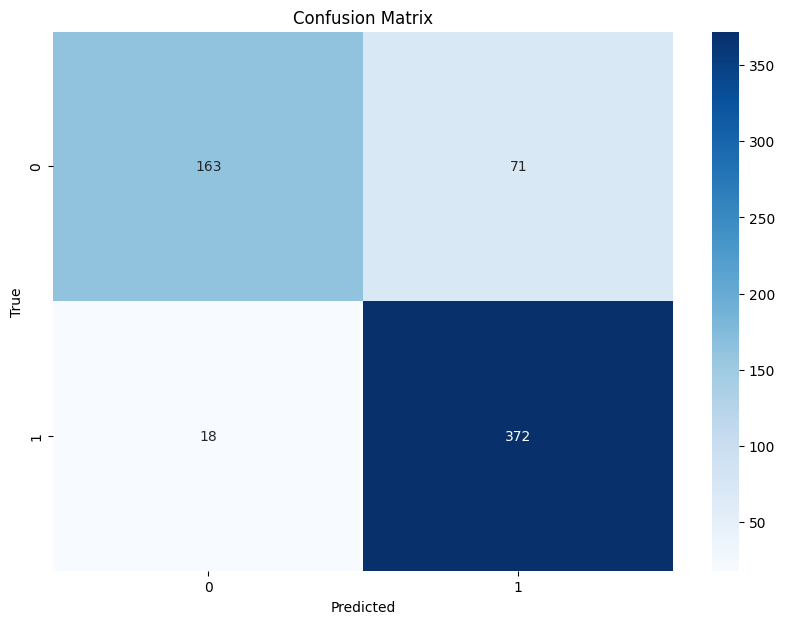

In [14]:
import seaborn as sns
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

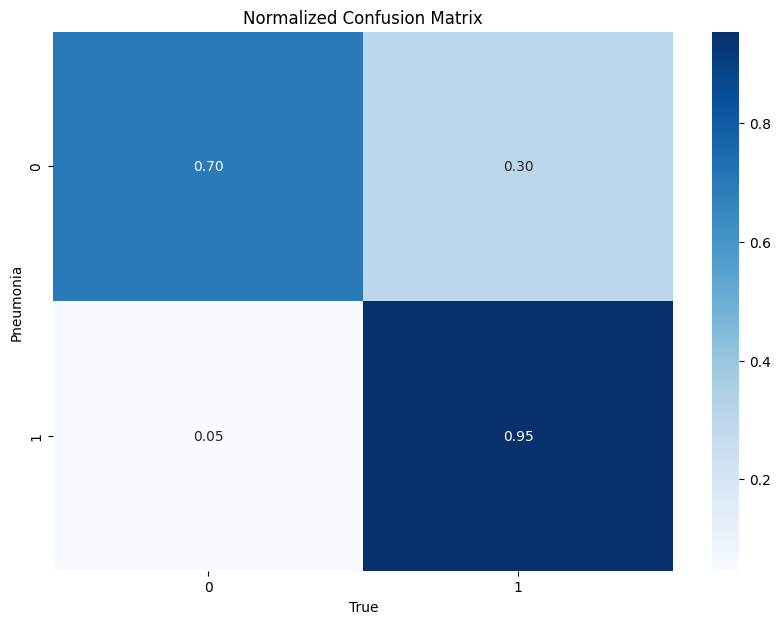

In [21]:
# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('True')
plt.ylabel('Pneumonia')
plt.title('Normalized Confusion Matrix')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 909ms/step


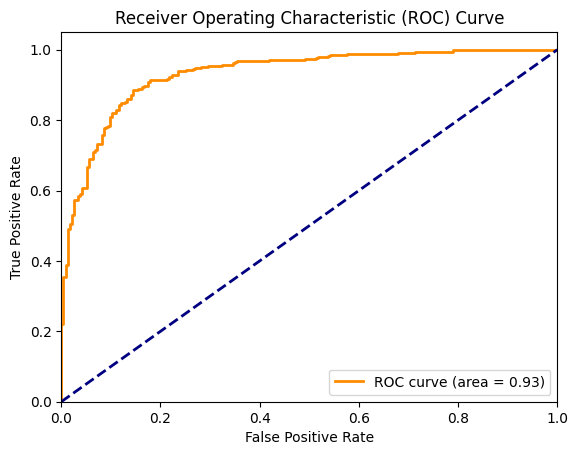

In [16]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = model.predict(test_data_gen).ravel()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
# Collect images and true labels
x_test = []
y_test = []

test_data_gen.reset()
for _ in range(len(test_data_gen)):
    imgs, labels = next(test_data_gen)
    for img, label in zip(imgs, labels):
        x_test.append(img)
        y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)


20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step


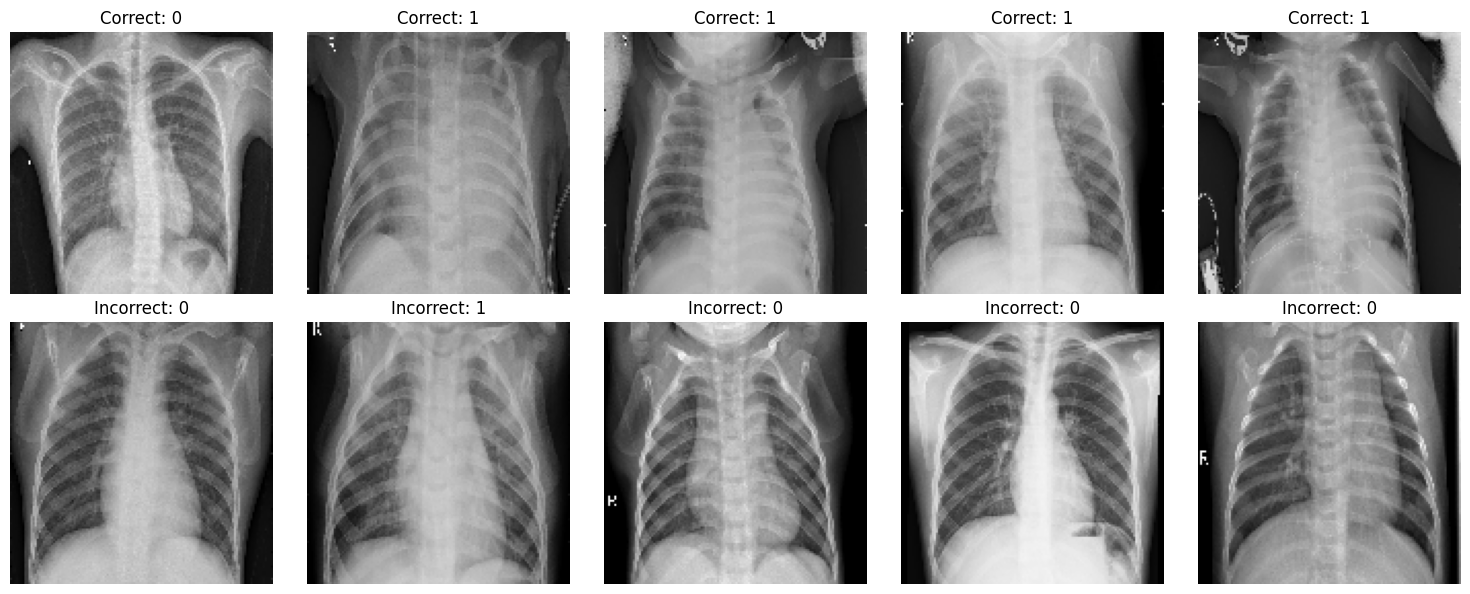

In [18]:
import random 

# Convert predictions and true labels to integer arrays
y_pred = (model.predict(x_test) > 0.5).astype("int32").flatten()
y_true = y_test.astype("int32").flatten()

# Identify correct and incorrect predictions
correct = np.where(y_pred == y_true)[0]
incorrect = np.where(y_pred != y_true)[0]

# Plot examples of correct and incorrect predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(5):
    idx = random.choice(correct)
    img = x_test[idx]
    axes[i].imshow(img)
    axes[i].set_title(f"Correct: {y_true[idx]}")
    axes[i].axis('off')

for i in range(5, 10):
    idx = random.choice(incorrect)
    img = x_test[idx]
    axes[i].imshow(img)
    axes[i].set_title(f"Incorrect: {y_true[idx]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,159,089 (103.60 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 4,198,408 (16.02 MB)

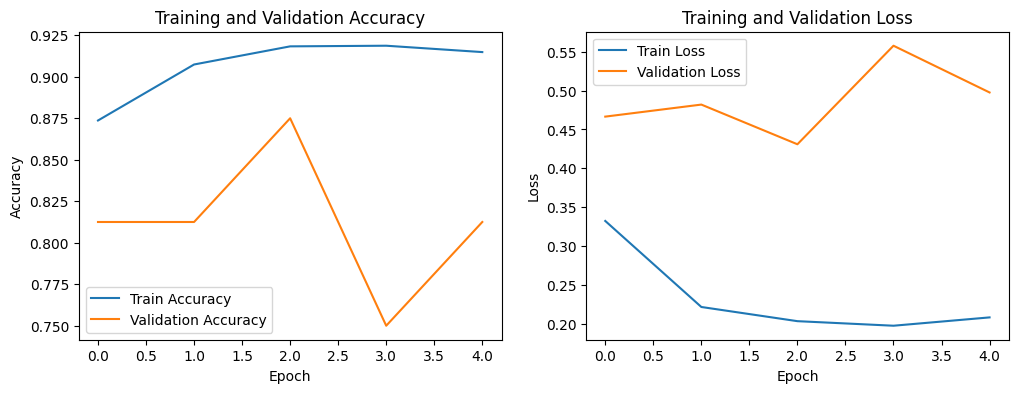

In [20]:
# Plotting
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

Explain why recall is important for these purposes. Explain how this can be used
Set the stage
Explain our methodology
Each person explain their approach
Hones in on highest f1, accuracy and recall model and talk about that
